In [0]:
from google.colab import drive


FOLDERNAME = 'damaged_structures_detector/images'

drive.mount('/content/drive', force_remount=True)

# assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd images/
# # !bash get_datasets.sh
# %cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


# New Section

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler, RandomSampler
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

from __future__ import print_function 
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


In [0]:
# class MyData(Dataset):
#     def __init__(self, data, target, transform=None):
#         self.data = data
#         self.target = target
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.target[index]
        
#         if (y == 1) and self.transform: # check for minority class
#             x = self.transform(x)
        
#         return x, y

In [0]:
#### augment datasets 

image_dir = "damaged_structures_detector/images"

def augment_images(directory=None, rotate_angle = 90 ):
    filenames = os.listdir(directory)
    # print(len(filenames))
    for filename in filenames:
      if '_' not in filename:
        # image = utils.load_image_and_preprocess()
        angle = rotate_angle
        print(filename)
        while angle < 360:
            # print(angle)
            im = Image.open(os.path.join(directory,filename))
            # arr = np.array(im)
            # plt.imshow(arr)
            # plt.show()
            im = im.rotate(angle)
            new_filename = os.path.splitext(filename)[0]+'_rotate_%s.jpg'%angle
            # print(new_filename)
            # im.save(os.path.join(directory,filename, "JPG")
            im.save(os.path.join(directory,new_filename))
            # arr = np.array(im)
            # plt.imshow(arr)
            # plt.show()
            angle += rotate_angle
            # count += 1
        im = Image.open(os.path.join(directory,filename))
        im = ImageOps.flip(im)
        new_filename = os.path.splitext(filename)[0]+'_flip.jpg'
        im.save(os.path.join(directory,new_filename))
        print(os.path.join(directory,new_filename))
        im = Image.open(os.path.join(directory,filename))
        im = ImageOps.mirror(im)
        new_filename = os.path.splitext(filename)[0]+'_mirror.jpg'
        im.save(os.path.join(directory,new_filename))

      # break
#### run only once for augment
# augment_images(os.path.join(image_dir,'val','not_destroyed'))

# New Section

In [0]:
# filenames = os.listdir(os.path.join(image_dir,'val','not_destroyed'))
# print(len(filenames))

In [0]:
data_transform = transforms.Compose([
        # transforms.RandomSizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomRotation((90,270)),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = None)

# print(train_dataset.imgs)
# dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
#                                              batch_size=4, shuffle=True,
#                                              num_workers=4)

In [0]:
NUM_TRAIN = 100

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
# cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
#                              transform=transform)
BATCH_SIZE = 128
loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
                          # sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE,  shuffle = True)
                        # sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# print(loader_train.d)

dataloaders_dict = {}
dataloaders_dict.update( {'train' : loader_train} )
dataloaders_dict.update( {'val' : loader_val} )
dataloaders_dict.update( {'test' : loader_test} )

In [0]:
# for inputs, labels in loader_train:
#   print(labels.size())
#   print(labels.unique())
# loader_train.

In [0]:
#features, labels = data
#print(labels.unique())
#print(labels.size())

NameError: ignored

Initiate Tensorboard Summary writer

In [0]:
# # runs is the default directory to save log files
# writer = SummaryWriter("runs/CIFAR10")

# # get a batch of data
# examples = iter(loader_test)
# batch_of_data, target_labels = examples.next()

# # Plot a batch of data
# img_grid = torchvision.utils.make_grid(batch_of_data)
# writer.add_image('Cifar10 images', img_grid)

# # Visualize model
# writer.add_graph(model, batch_of_data)

# # make sure that outputs are flashed
# writer.close()


In [0]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
# batch_size = 5

# Number of epochs to train for 
num_epochs = 100

# Number of dataset examples and input shape
# examples_num, height, width, channels = loader_train.dataset.data.shape
height = 224
width = 224
channels = 3

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.

# New Section

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

The Following Function takes the model name, input dimensions, number of classes, feature extraction or finetuning, and pretrained or not and initializes the model. I only assume that the input image will have a square shape and even number of pixels in each dimensions (can easily modify if input needs to be different).

In [0]:
def initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """                
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft = nn.Sequential(first_conv_layer, model_ft)
  

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)
        

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))  
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

        if(width != input_size):       
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1
          
          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft.AuxLogits = nn.Sequential(first_conv_layer, model_ft.AuxLogits)
          model_ft = nn.Sequential(first_conv_layer, model_ft)


    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Move model to GPU and Create Optimizer

In [0]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.1, momentum=0.9,nesterov = True)
# optimizer_ft = optim.Adam()

# print(optimizer_ft.state_dict())

Params to learn:
	 fc.weight
	 fc.bias


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # print(labels.unique())
                # print(labels.size())
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    # if phase == 'train':
                      # if epoch ==0:
                      # print(preds.unique())
                      # print(labels.data.unique())
                      # print(labels.data.size())
                      # print(labels.data)
                      # print(labels.data.mean())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Add it to tensorboard writer
            #writer.add_scalar('training loss', epoch_loss, epoch)
            #writer.add_scalar('accuracy on val set', epoch_acc, epoch)



            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                checkpoint = {
                    "epoch" : epoch,
                    "model_state" : model_ft.state_dict(),
                    "optim_state" : optimizer_ft.state_dict(),
                    "val_loss" : epoch_loss,
                    "val_acc" : epoch_acc
                }
                CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
                torch.save(checkpoint, CHECKPOINT_PATH)

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

# New Section

Epoch 0/99
----------
train Loss: 0.8492 Acc: 0.8866
val Loss: 1.9388 Acc: 0.7987
Epoch 1/99
----------
train Loss: 0.9064 Acc: 0.8868
val Loss: 2.2309 Acc: 0.7819
Epoch 2/99
----------
train Loss: 0.7718 Acc: 0.8981
val Loss: 0.8491 Acc: 0.8867
Epoch 3/99
----------
train Loss: 0.8407 Acc: 0.8876
val Loss: 0.5309 Acc: 0.9167
Epoch 4/99
----------
train Loss: 0.8046 Acc: 0.8908
val Loss: 2.8506 Acc: 0.6982
Epoch 5/99
----------
train Loss: 0.9281 Acc: 0.8902
val Loss: 0.5744 Acc: 0.9245
Epoch 6/99
----------
train Loss: 0.7912 Acc: 0.8943
val Loss: 3.5464 Acc: 0.6671
Epoch 7/99
----------
train Loss: 0.7849 Acc: 0.8982
val Loss: 0.9651 Acc: 0.8719
Epoch 8/99
----------
train Loss: 0.8402 Acc: 0.8883
val Loss: 1.4033 Acc: 0.8244
Epoch 9/99
----------
train Loss: 0.6944 Acc: 0.9015
val Loss: 10.8966 Acc: 0.4805
Epoch 10/99
----------
train Loss: 0.8124 Acc: 0.8936
val Loss: 0.5412 Acc: 0.9097
Epoch 11/99
----------
train Loss: 0.7512 Acc: 0.8955
val Loss: 1.0265 Acc: 0.8836
Epoch 12/99
-

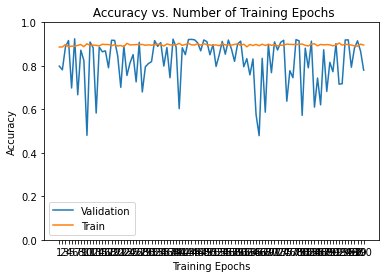

AttributeError: ignored

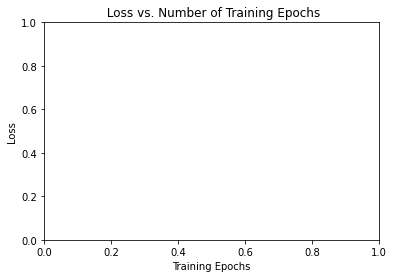

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method
ohist = []

# ohist = [h.cpu().numpy() for h in hist[0]]

plt.title(" Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),[h.cpu().numpy() for h in hist[0]],label="Validation")
plt.plot(range(1,num_epochs+1),[h.cpu().numpy() for h in hist[2]],label="Train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


plt.title(" Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),[h.cpu().numpy() for h in hist[1]],label="Validation")
plt.plot(range(1,num_epochs+1),[h.cpu().numpy() for h in hist[3]],label="Train")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [0]:
CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
loaded_checkpoint = torch.load(CHECKPOINT_PATH)
epoch = loaded_checkpoint["epoch"]
model_state = loaded_checkpoint["model_state"]
optim_state = loaded_checkpoint["optim_state"]
val_loss = loaded_checkpoint["val_loss"]
val_acc = loaded_checkpoint["val_acc"]

best_model, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
best_model.load_state_dict(model_state)
best_model.to(device)
epoch

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# optimizer_ft.load_state_dict(optim_state)

5

# New Section

# New Section

BATCH size | Time per 10 epochs
128 | 16 mins


Save Model or Checkpoint

In [0]:
# FILE = "model_ft.pth"
# # torch.save(model_ft.state_dict(), FILE)

# checkpoint = {
#     "epoch" : num_epochs,
#     "model_state" : model_ft.state_dict(),
#     "optim_state" : optimizer_ft.state_dict()
# }
# CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
# torch.save(checkpoint, CHECKPOINT_PATH)

Load Model (Needs initialization first)

In [0]:
# # loaded_model, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# # loaded_model.load_state_dict(torch.load(FILE))
# # loaded_model.eval()

# loaded_checkpoint = torch.load(CHECKPOINT_PATH)
# epoch = checkpoint["epoch"]
# model_state = checkpoint["model_state"]
# optim_state = checkpoint["optim_state"]

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# optimizer_ft.load_state_dict(optim_state)

loaded_checkpoint = torch.load(CHECKPOINT_PATH)loaded_checkpoint = torch.load(CHECKPOINT_PATH)loaded_checkpoint = torch.load(CHECKPOINT_PATH)loaded_checkpoint = torch.load# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

Save on GPU, Load on CPU

In [0]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# device = torch.device('cpu')
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location=device))

Save GPU, Load GPU

In [0]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE))
# model.to(device)

Save CPU, Load GPU

In [0]:
# torch.save(model_ft.state_dict(), FILE)

# device = torch.device("cuda")
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location="cuda:0"))
# model.to(device)